In [ ]:
#| default_exp magviz

In [ ]:
#| export
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

In [ ]:
#| export
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1).astype(np.float32)

In [ ]:
#| export
def create_physical_coordinates(bounds, resolutions):
    x_1D = np.linspace(bounds[0], bounds[1], resolutions[0])
    y_1D = np.linspace(bounds[2], bounds[3], resolutions[1])
    z_1D = np.linspace(bounds[4], bounds[5], resolutions[2])
    x_spacing = np.diff(x_1D)[0]
    y_spacing = np.diff(y_1D)[0]
    z_spacing = np.diff(z_1D)[0]
    spacing = (x_spacing, y_spacing, z_spacing)
    origin = (x_1D[0], y_1D[0], z_1D[0]) # The bottom left corner of the data set
    grid = pv.ImageData(dimensions=resolutions, spacing=spacing, origin=origin)
    return grid

In [ ]:
#| eval:false
pv.set_jupyter_backend('static')
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True

In [ ]:
#| export
class mag_plotter:
    def __init__(self, grd):
        grid = copy.deepcopy(grd)
        self.grid = grid
        x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
        Nx, Ny, Nz = self.grid.dimensions
        x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1

        self.x_ind_min, self.y_ind_min, self.z_ind_min = x_ind_min, y_ind_min, z_ind_min
        self.x_ind_max, self.y_ind_max, self.z_ind_max = x_ind_max, y_ind_max, z_ind_max
        
        bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
        bottom = self.grid.extract_subset(bottom_subset).extract_surface()
        bottom.active_vectors_name = 'B'
        bottom.active_scalars_name = 'mag'

        self.bottom = bottom

        self.x_bottom = bottom.points[:, 0].reshape(Nx, Ny)
        self.y_bottom = bottom.points[:, 1].reshape(Nx, Ny)
        self.B_bottom = bottom['B'].reshape(Nx, Ny, 3)

        B = self.grid['B'].reshape(Nz, Ny, Nx, 3)
        self.B = B.transpose(2, 1, 0, 3)

    def plt_Bz(self):
        plt.close()
        fig, ax = plt.subplots(figsize=(6,6))
        CS = plt.contour(self.x_bottom, self.y_bottom, self.B_bottom[:, :, 2], 
                         origin='lower', colors='k')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.clabel(CS, fontsize=9, inline=True)
        ax.set_title(r"$B_z(z=0)$")
        plt.show()

    def pv_bottom(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        p.add_mesh(self.bottom)
        p.show()

    def pv_Bz_2D(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs = dict(title="B_z")
        ctr = self.bottom.contour(scalars=self.bottom['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs)
        p.show()

    def pv_Bz_3D(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs = dict(title="B_z")
        ctr = self.grid.contour(scalars=self.grid['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs, opacity=0.5)
        p.show()

    def pv_streamline(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        i_size = self.grid.bounds[1]-self.grid.bounds[0]
        j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=10, j_resolution=10)
        p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        p.add_mesh(strl.tube(radius=i_size/400), cmap='bwr', ambient=0.2)

        sargs = dict(title="B_z")
        ctr = self.bottom.contour(scalars=self.bottom['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs)
        p.show()

    def pv_streamline_Bz(self, window_size=None, title=None, title_fontsize=20, camera_position=None, i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-2000, vmax=2000):
        p = pv.Plotter()
        # p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs_B = dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        )
        dargs_B = dict(
            scalars='B', 
            component=2, 
            clim=(vmin, vmax), 
            scalar_bar_args=sargs_B, 
            show_scalar_bar=True, 
            lighting=False
        )
        p.add_mesh(self.bottom, cmap='gray', **dargs_B)

        if (i_siz is not None) and (j_siz is not None):
            i_size = i_siz
            j_size = j_siz
        else:
            i_size = self.grid.bounds[1]-self.grid.bounds[0]
            j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=i_resolution, j_resolution=j_resolution)
        # p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        p.add_mesh(strl.tube(radius=i_size/400), 
                   lighting=False,
                   color='blue')
        if camera_position is not None:
             p.camera_position = camera_position
        if window_size is not None:
            p.window_size = window_size
        if title is not None:
            p.add_title(title, font_size=title_fontsize)
        p.show()
        return p
    
    def create_mesh(self, i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-2000, vmax=2000):
        if (i_siz is not None) and (j_siz is not None):
            i_size = i_siz
            j_size = j_siz
        else:
            i_size = self.grid.bounds[1]-self.grid.bounds[0]
            j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=i_resolution, j_resolution=j_resolution)
        # p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        sargs_B = dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        )
        dargs_B = dict(
            scalars='B', 
            component=2, 
            clim=(vmin, vmax), 
            scalar_bar_args=sargs_B, 
            lighting=False
        )

        self.tube = strl.tube(radius=i_size/400)
        self.dargs_B = dargs_B        
        return strl.tube(radius=i_size/400), self.bottom, dargs_B

    def plt_Bz_imshow(self, z=0, vmin=None, vmax=None, title=None, fontsize=20):         
        plt.close()
        fig, ax = plt.subplots(figsize=(6,6))
        if (vmin is not None) and (vmax is not None):
            CS = plt.imshow(self.B[:, :, z, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        else:
            CS = plt.imshow(self.B[:, :, z, 2].transpose(), origin='lower', cmap='gray')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        # ax.set_title(f"B_z(z={z})")
        if title is not None:
            ax.set_title(title, fontsize=fontsize)
        fig.colorbar(CS, label=r'$B_z$'+f'(z={z})')
        plt.show()

In [ ]:
b_mesh = pv.read('../data/b.vtk')

In [ ]:
b_mesh

ImageData (0x7fb1f0c86080)
  N Cells:      250047
  N Points:     262144
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   64, 64, 64
  Spacing:      3.175e-02, 3.175e-02, 3.175e-02
  N Arrays:     3

In [ ]:
b = mag_plotter(b_mesh)

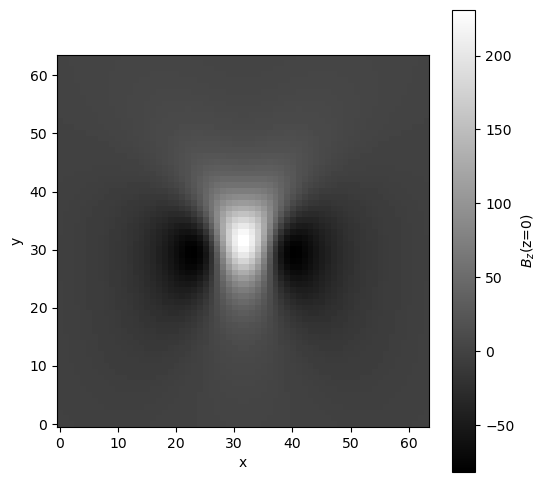

In [ ]:
b.plt_Bz_imshow()

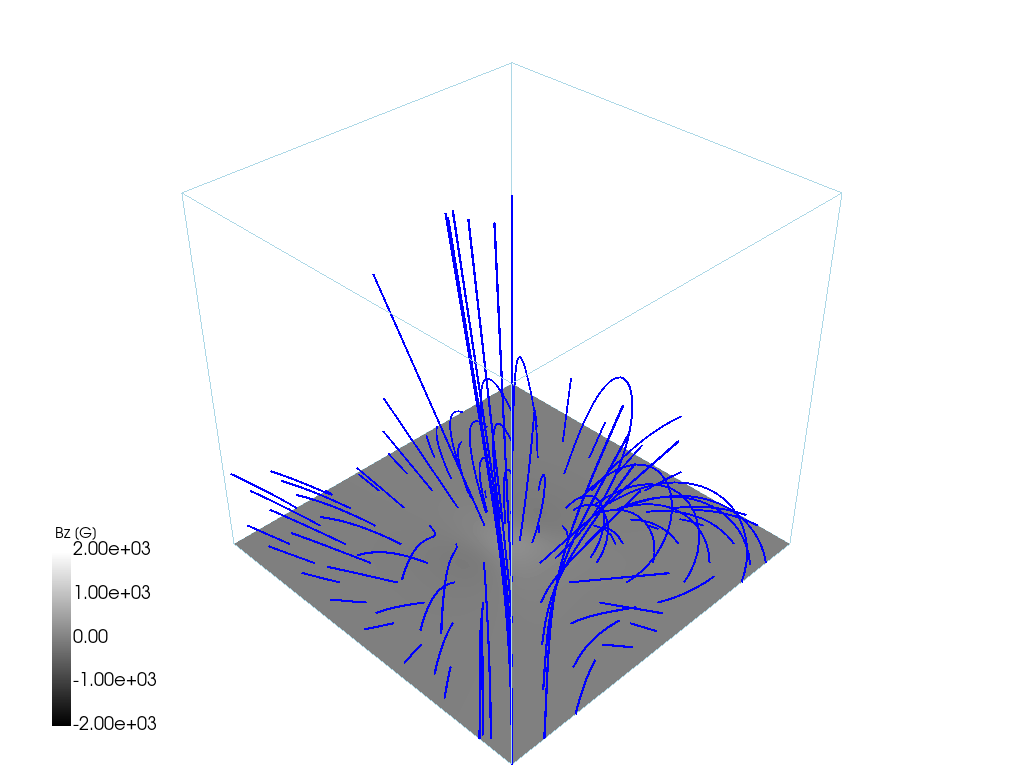

<pyvista.plotting.plotter.Plotter>

In [ ]:
b.pv_streamline_Bz()

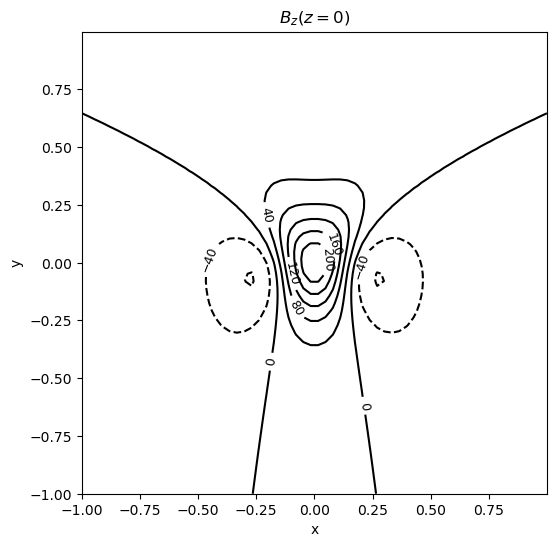

In [ ]:
b.plt_Bz()

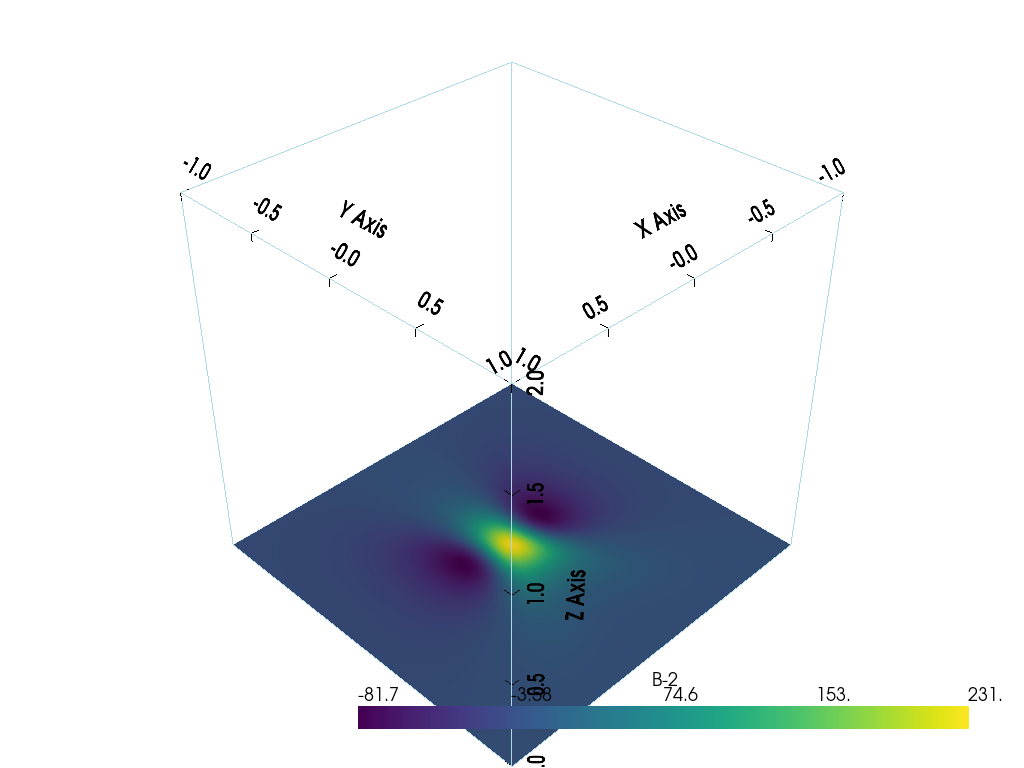

In [ ]:
b.pv_bottom()

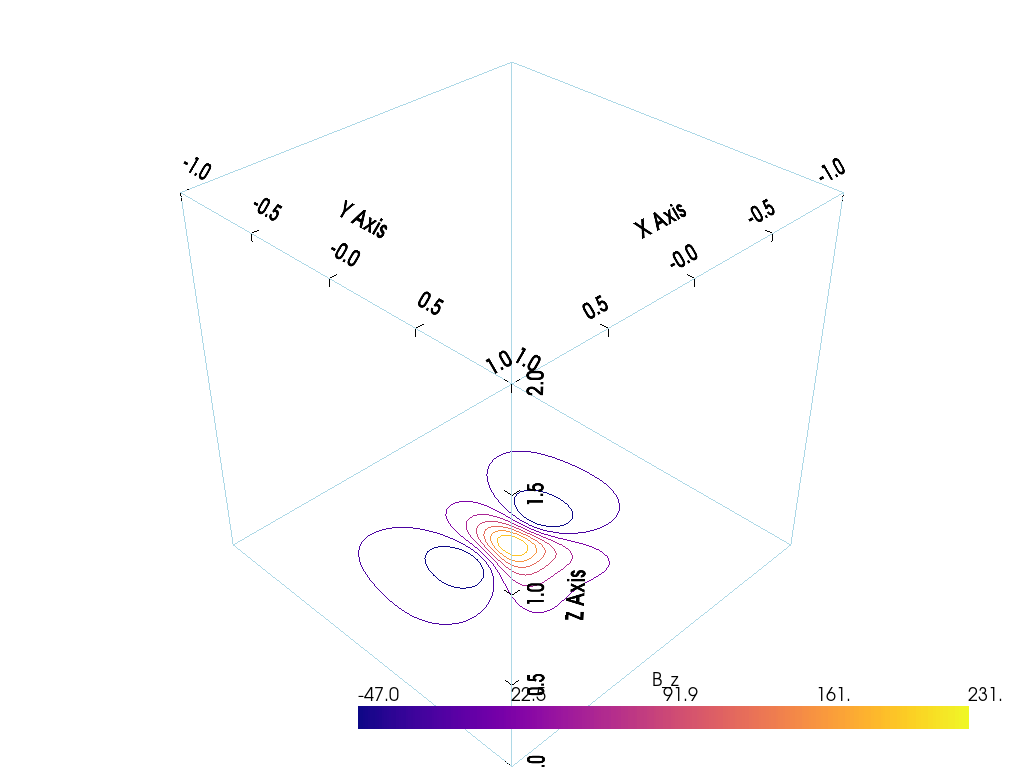

In [ ]:
b.pv_Bz_2D()

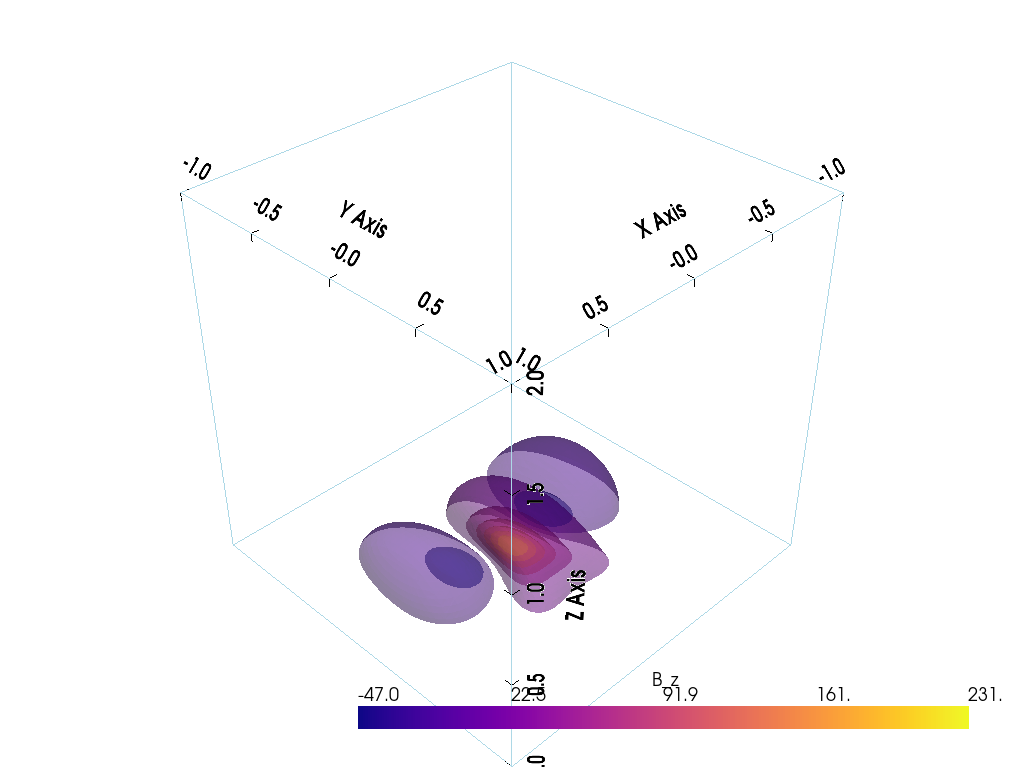

In [ ]:
b.pv_Bz_3D()

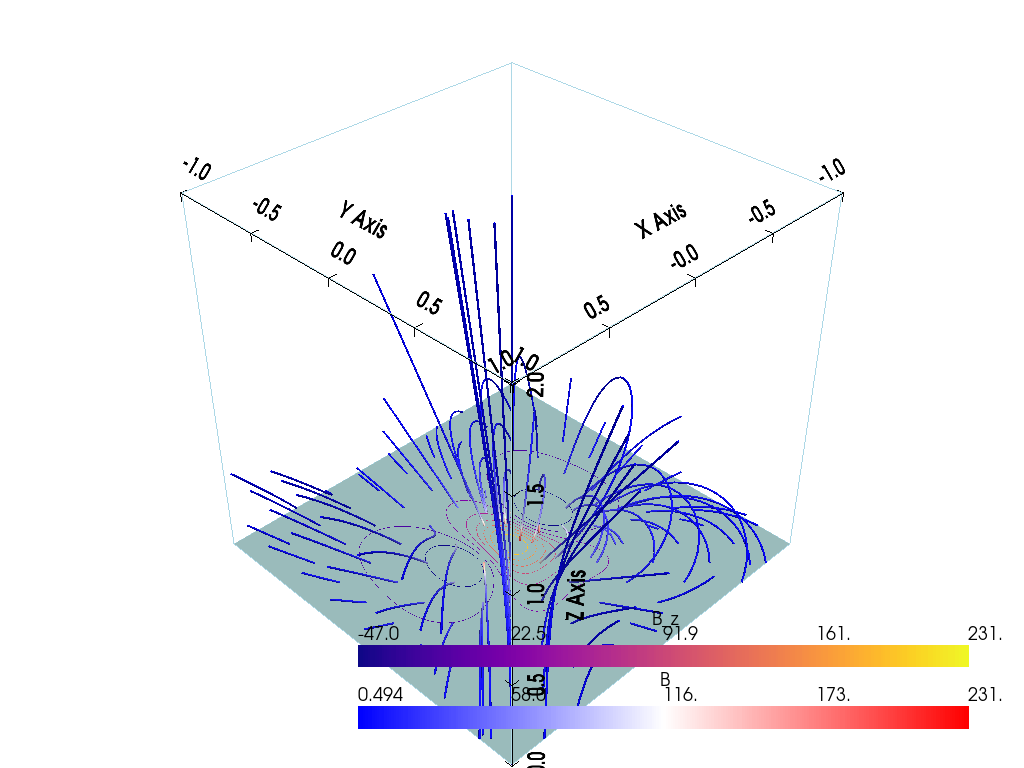

In [ ]:
b.pv_streamline()

In [ ]:
b.create_mesh()

(PolyData (0x7fb1c44db6a0)
   N Cells:    2002
   N Points:   34140
   N Strips:   2002
   X Bounds:   -1.005e+00, 1.004e+00
   Y Bounds:   -1.005e+00, 1.005e+00
   Z Bounds:   -5.182e-03, 1.996e+00
   N Arrays:   12,
 PolyData (0x7fb1f0c84100)
   N Cells:    3969
   N Points:   4096
   N Strips:   0
   X Bounds:   -1.000e+00, 1.000e+00
   Y Bounds:   -1.000e+00, 1.000e+00
   Z Bounds:   0.000e+00, 0.000e+00
   N Arrays:   7,
 {'scalars': 'B',
  'component': 2,
  'clim': (-2000, 2000),
  'scalar_bar_args': {'title': 'Bz [G]',
   'title_font_size': 15,
   'height': 0.25,
   'width': 0.05,
   'vertical': True,
   'position_x': 0.05,
   'position_y': 0.05},
  'lighting': False})

In [ ]:
p = pv.Plotter() 
p.add